In [62]:
import warnings
warnings.filterwarnings("ignore")

#import libraries
import pandas as pd
import numpy as np
from pandas import datetime
from sklearn.model_selection import train_test_split
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
#from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf


# prophet by Facebook
from fbprophet import Prophet

In [63]:
# Loading the training data set
train = pd.read_csv(r'/content/train.csv', parse_dates = True, low_memory = False, index_col = 'Date')

# Explanatory Data Analysis

In [64]:
# Extract date variables as colums for the trainig data
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


In [65]:
# adding new variable - SalesPerCustomer
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

- On an average a customer spends around 9.5 dollars per day in a store.
- There are also a few days where the sales are zero and we can check if the store is open or not those days

In [66]:
# closed stores and zero sales
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 13)

In [67]:
# open stores and zero sales
train[(train.Open == 1) & (train.Sales == 0)].shape

(54, 13)

- For 54 days the store is open and the sales are zero

In [68]:
# Consider the additional data we have - store data
store = pd.read_csv(r'/content/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [69]:
# check for missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# for competitionDistance there are just 3 values missing so we can substiute with the median values
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [ ]:
store[(store.Promo2 == 0)].shape

(544, 10)

- As promo2 is zero, it is logical that we have missing values for promo2sinceweek and year. so we replace them with zeros


In [ ]:
store.fillna(0, inplace = True)

In [71]:
# merge the datasets based on store
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

In [72]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [73]:
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
SalesPerCustomer             172869
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

- For data where the sales and number of customers are zero, the salesPerCustomer is undefined, so we can replace it with zeros.

In [74]:
train_store.fillna(0, inplace=True)

In [75]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


- From above, we can infer that storeType b has more sales followed by a, c and d

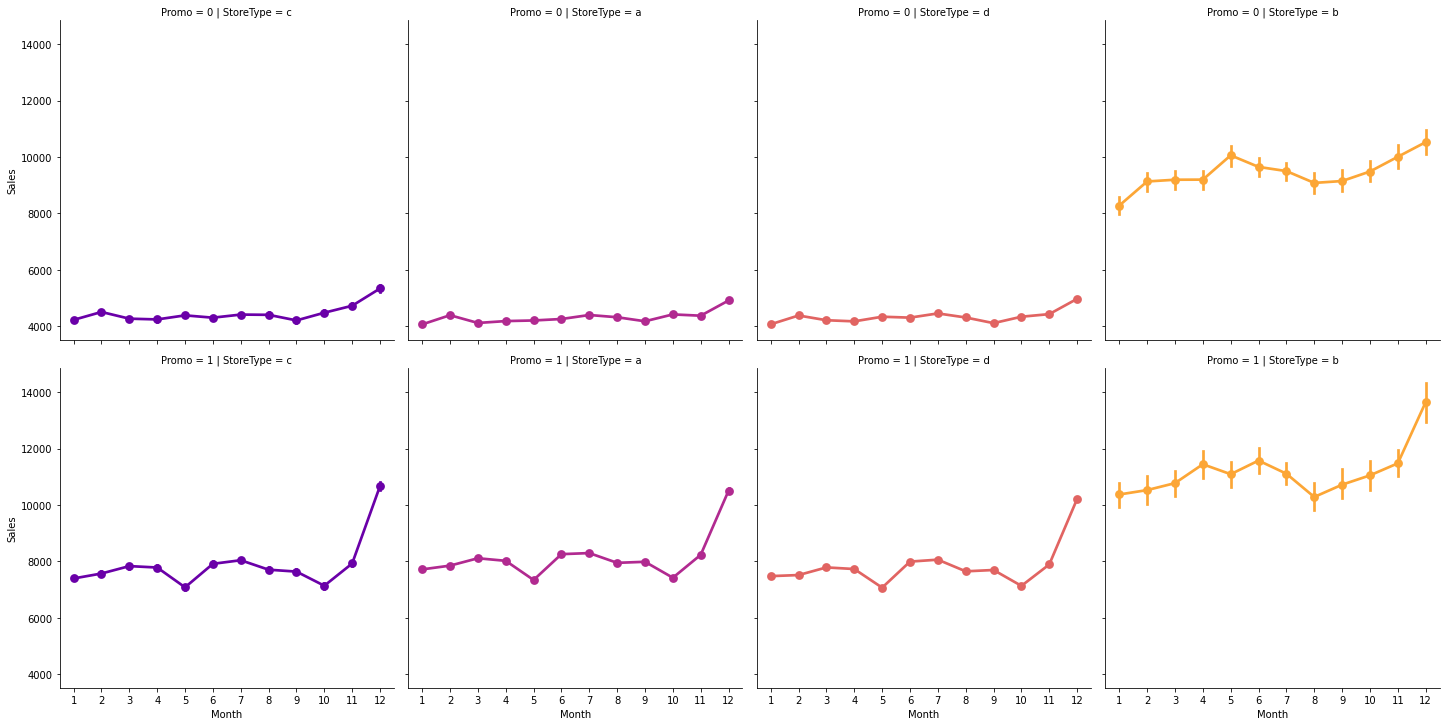

In [76]:
# sales trends for each storeType depending on if there is promotion or not 
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- According to the results above we can see that sales hike up during christmas especially if there is a promotion. 
- Without promotion there is a slight hike compared to the rest of the time.
- Also storeType b has more sales compared to other stores.

In [77]:
# Number of customers for each storeType depending on if there is promotion or not 
train_store.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,659.034880,462.930320,0.0,414.0,647.0,890.0,7388.0
b,15830.0,1987.720846,940.088627,0.0,1228.0,1820.0,2732.0,5494.0
c,136840.0,673.265894,430.708776,0.0,455.0,682.0,924.0,3096.0
d,312912.0,501.434892,292.301770,0.0,375.0,530.0,681.0,2239.0


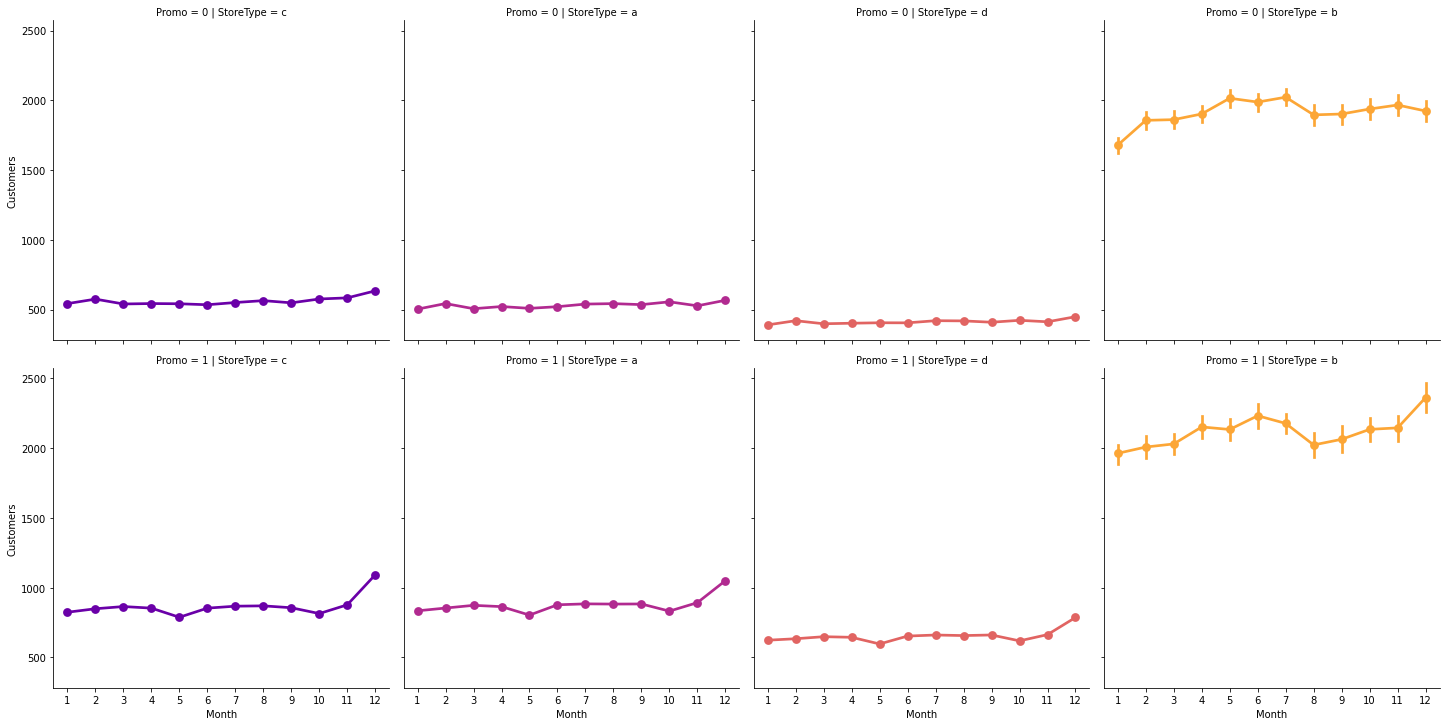

In [78]:
# # Number of customers for each storeType depending on if there is promotion or not 
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- There are more customers for store b compared to other stores.
- Similarly more customers during christmas if there is a promotion.
- Without promotion the there are more or less same number of customer through out the year for storeTpye a, c and d


In [79]:
# Sales per Customer value for each storeType depending on if there is promotion or not 
train_store.groupby('StoreType')['SalesPerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,7.329461,3.672402,0.0,6.805664,8.205339,9.592742,29.877551
b,15830.0,5.045870,1.409784,0.0,4.009505,4.947420,6.085210,9.203528
c,136840.0,7.121365,3.617551,0.0,6.624305,8.000357,9.334980,64.957854
d,312912.0,9.326423,4.634349,0.0,8.738610,10.669221,12.236648,57.614983


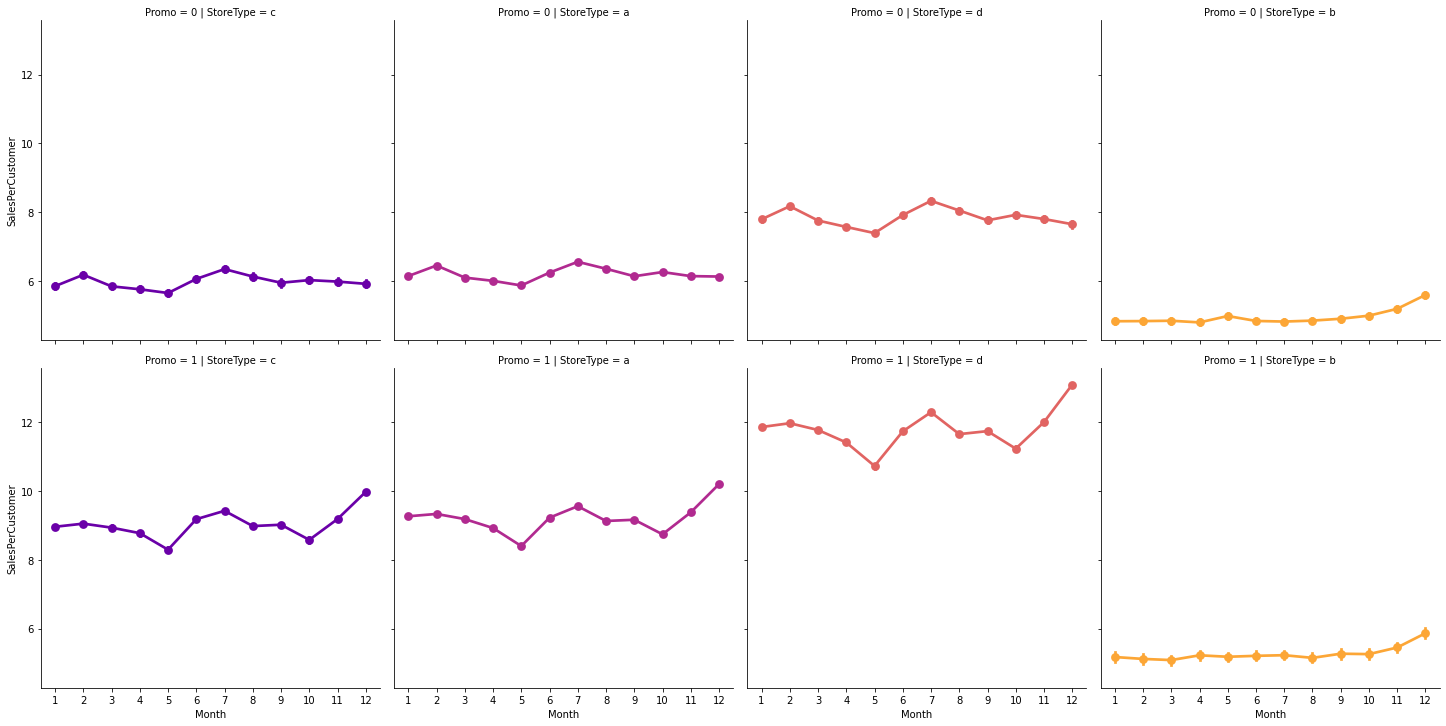

In [80]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo' # per promo in the store in rows
               )

- As we can see from the above result, storeType d has more salesPerCustomers. 
- StoreType b has more customers and sales, but less salespercustomer value which means people come to buy small things or less quantity.
- StoreType d has an average of 12 dollars with promotion and around 11 dollars without promotion
- StoreType a and c have a maximum of around 10 dollars during promotion and 6 dollars without promotion

In [82]:
# Sales for each assortment depending on if there is promotion or not 
train_store.groupby('Assortment')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,5481.026096,3682.766186,0.0,3492.0,5463.0,7514.00,38722.0
b,8294.0,8553.931999,3882.418206,0.0,5523.0,8026.5,11233.25,22137.0
c,471470.0,6058.676567,3992.255662,0.0,4017.0,6039.0,8184.00,41551.0


In [83]:
train_store.groupby('Assortment')['SalesPerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,7.558109,3.891360,0.0,6.777056,8.334711,9.991150,57.614983
b,8294.0,4.121054,0.752622,0.0,3.700630,4.070811,4.520541,7.367793
c,471470.0,8.313561,4.272276,0.0,7.268803,9.217339,11.080871,64.957854


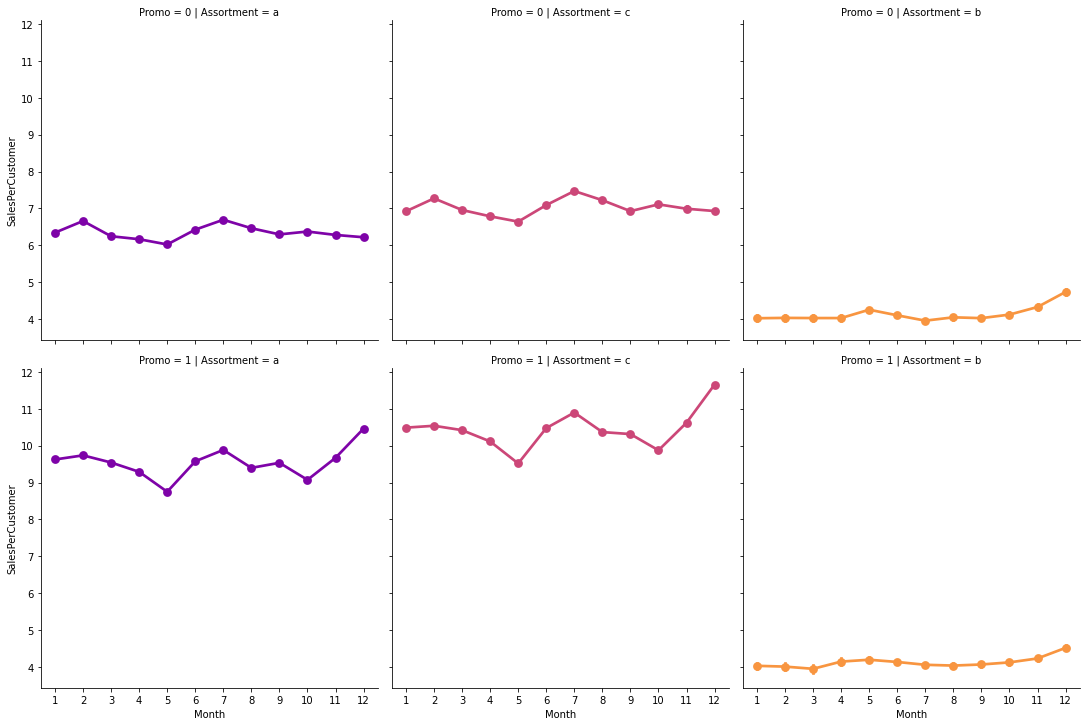

In [84]:
# # Sales per Customer value for each assortment depending on if there is promotion or not 
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'Assortment', # per store type in cols
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Promo' # per promo in the store in rows
               )

In [85]:
# Sales for each day of week 
train_store.groupby('DayOfWeek')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,144730.0,7809.044510,4016.526273,0.0,5235.00,7310.0,9972.0,41551.0
2,145664.0,7005.244467,3142.039607,0.0,4904.00,6463.0,8491.0,34692.0
3,145665.0,6555.884138,2944.377501,0.0,4718.00,6133.0,7926.0,33151.0
4,145845.0,6247.575913,3209.806360,0.0,4536.00,6020.0,7792.0,38367.0
5,145845.0,6723.274305,3101.006008,0.0,4975.00,6434.0,8206.0,38722.0
6,144730.0,5847.562599,2873.985615,0.0,3899.25,5410.0,7220.0,31683.0
7,144730.0,204.183189,1613.243517,0.0,0.00,0.0,0.0,37376.0


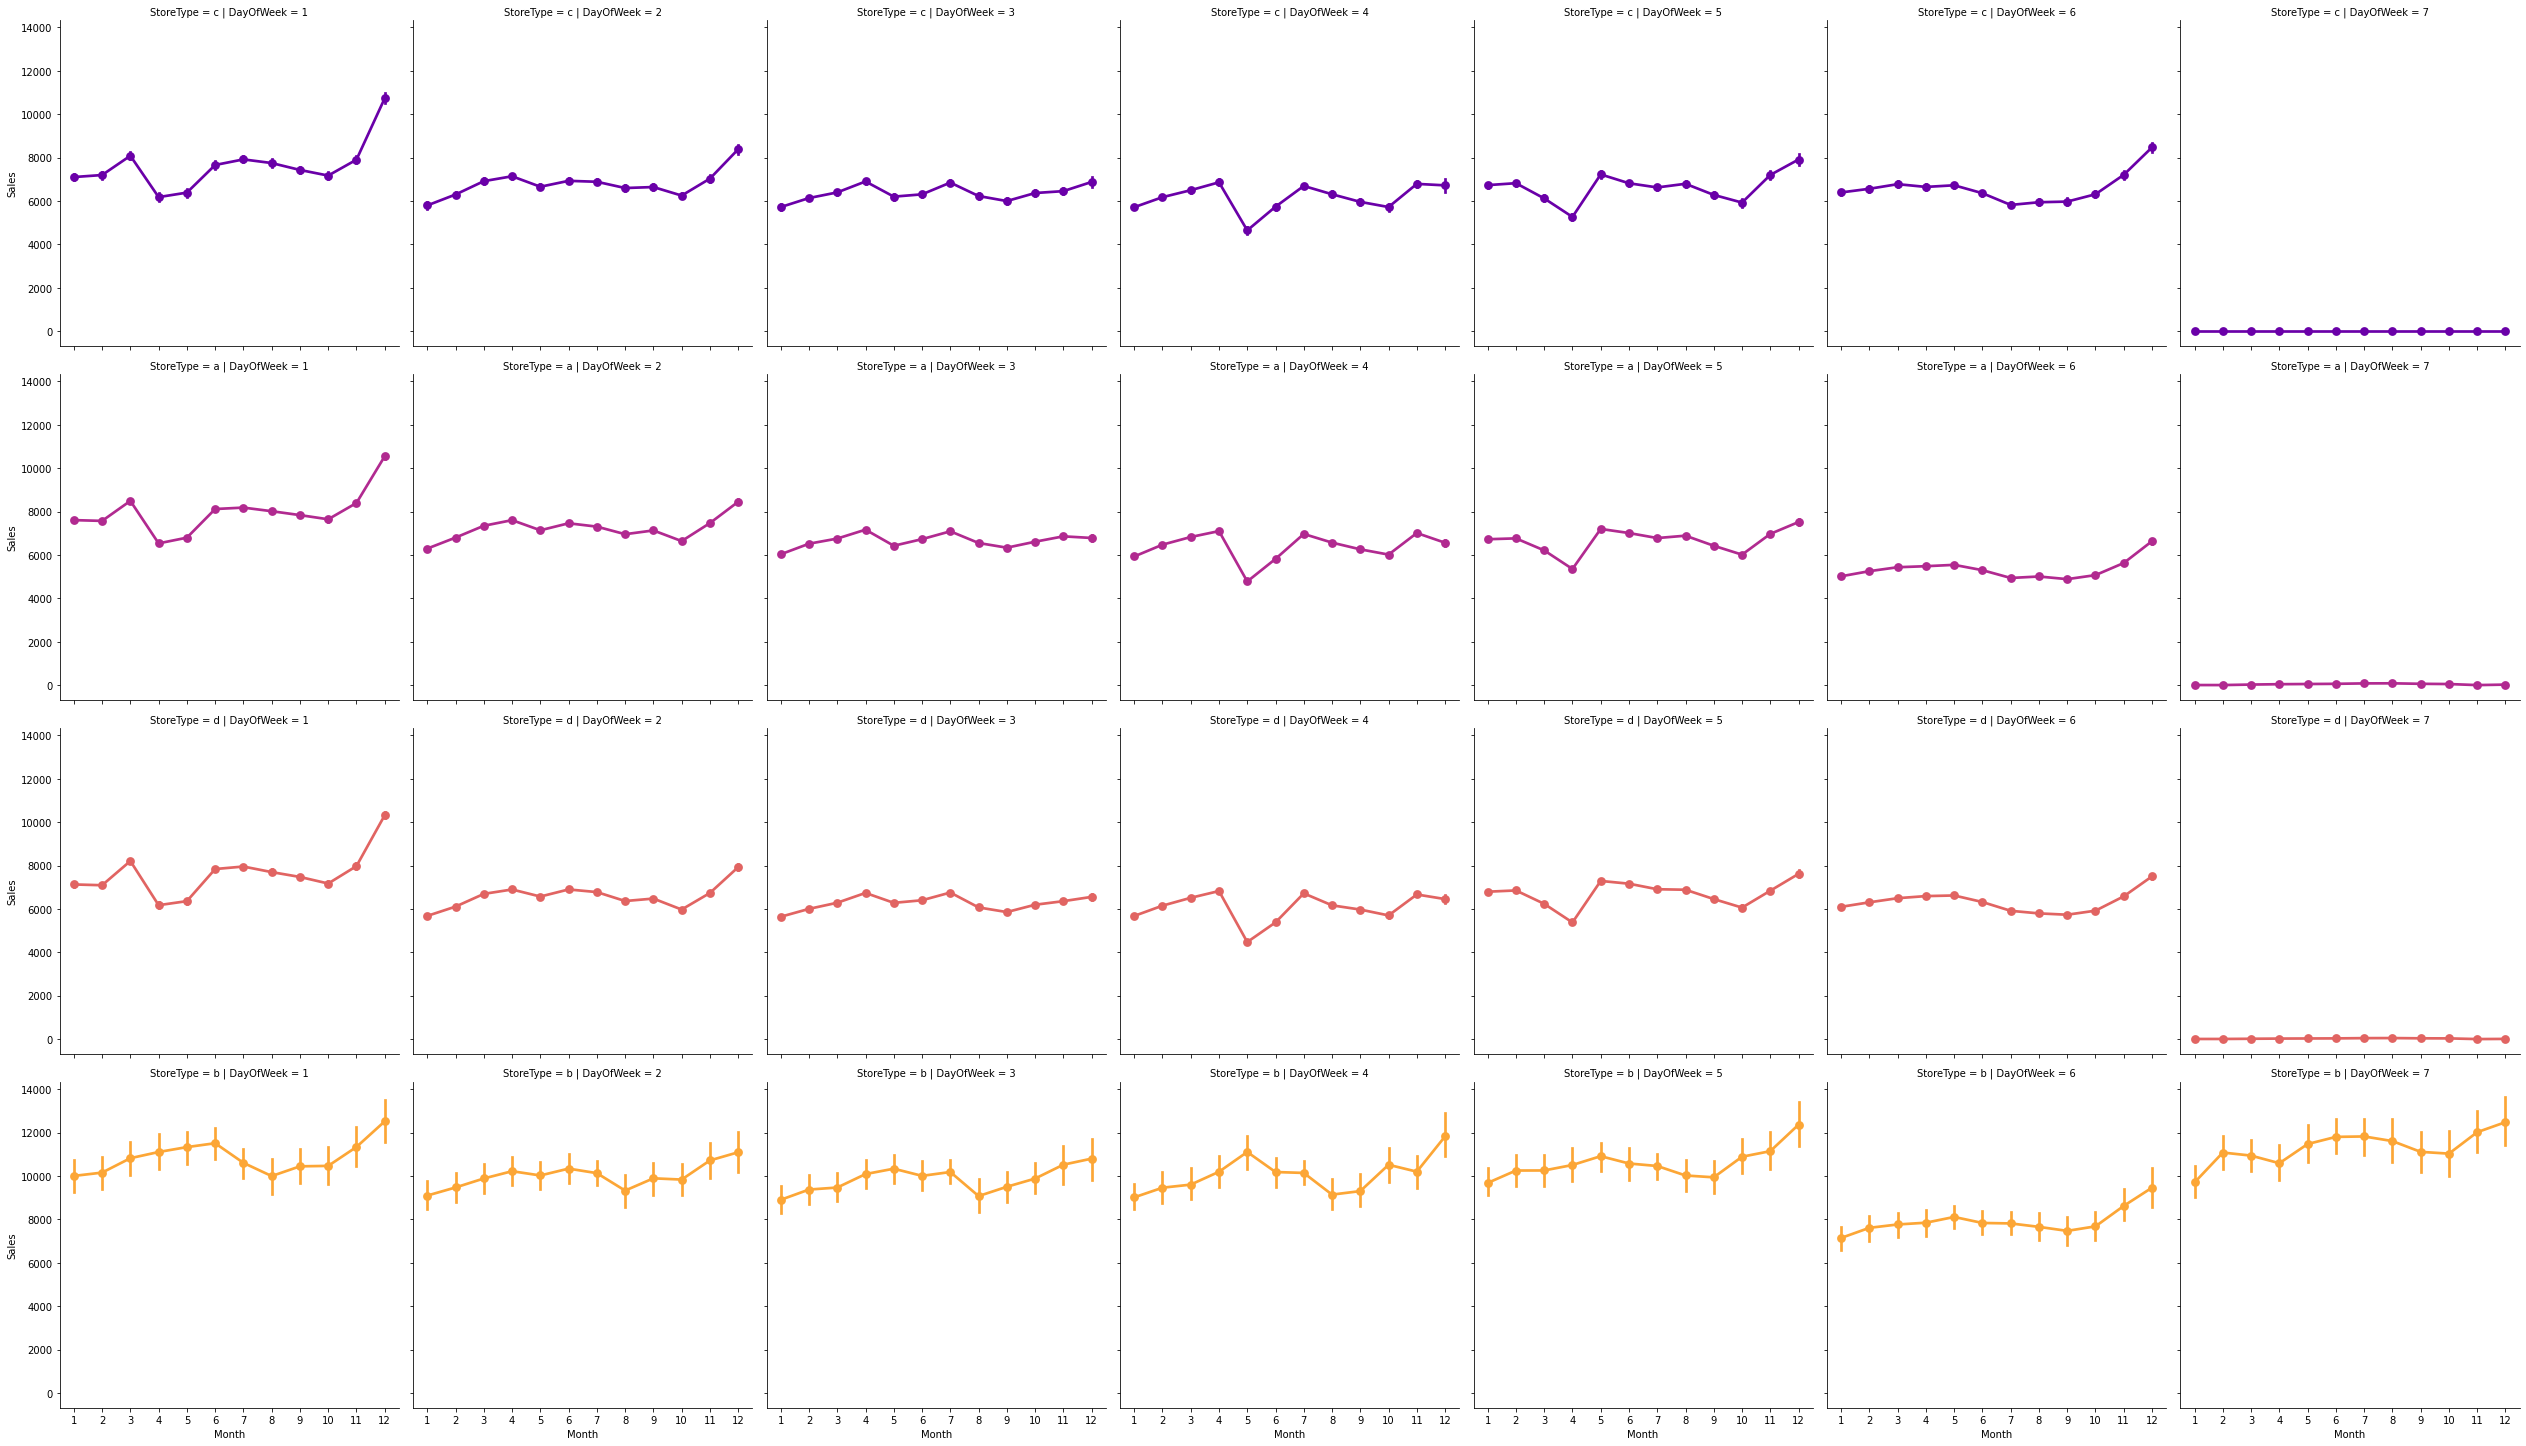

In [86]:
# Sales for each day of week
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType a,c,d are closed on sundays as the sales are zero.
- storeType b has more sales. On Saturdays it has less sales compared to the other days of the week.


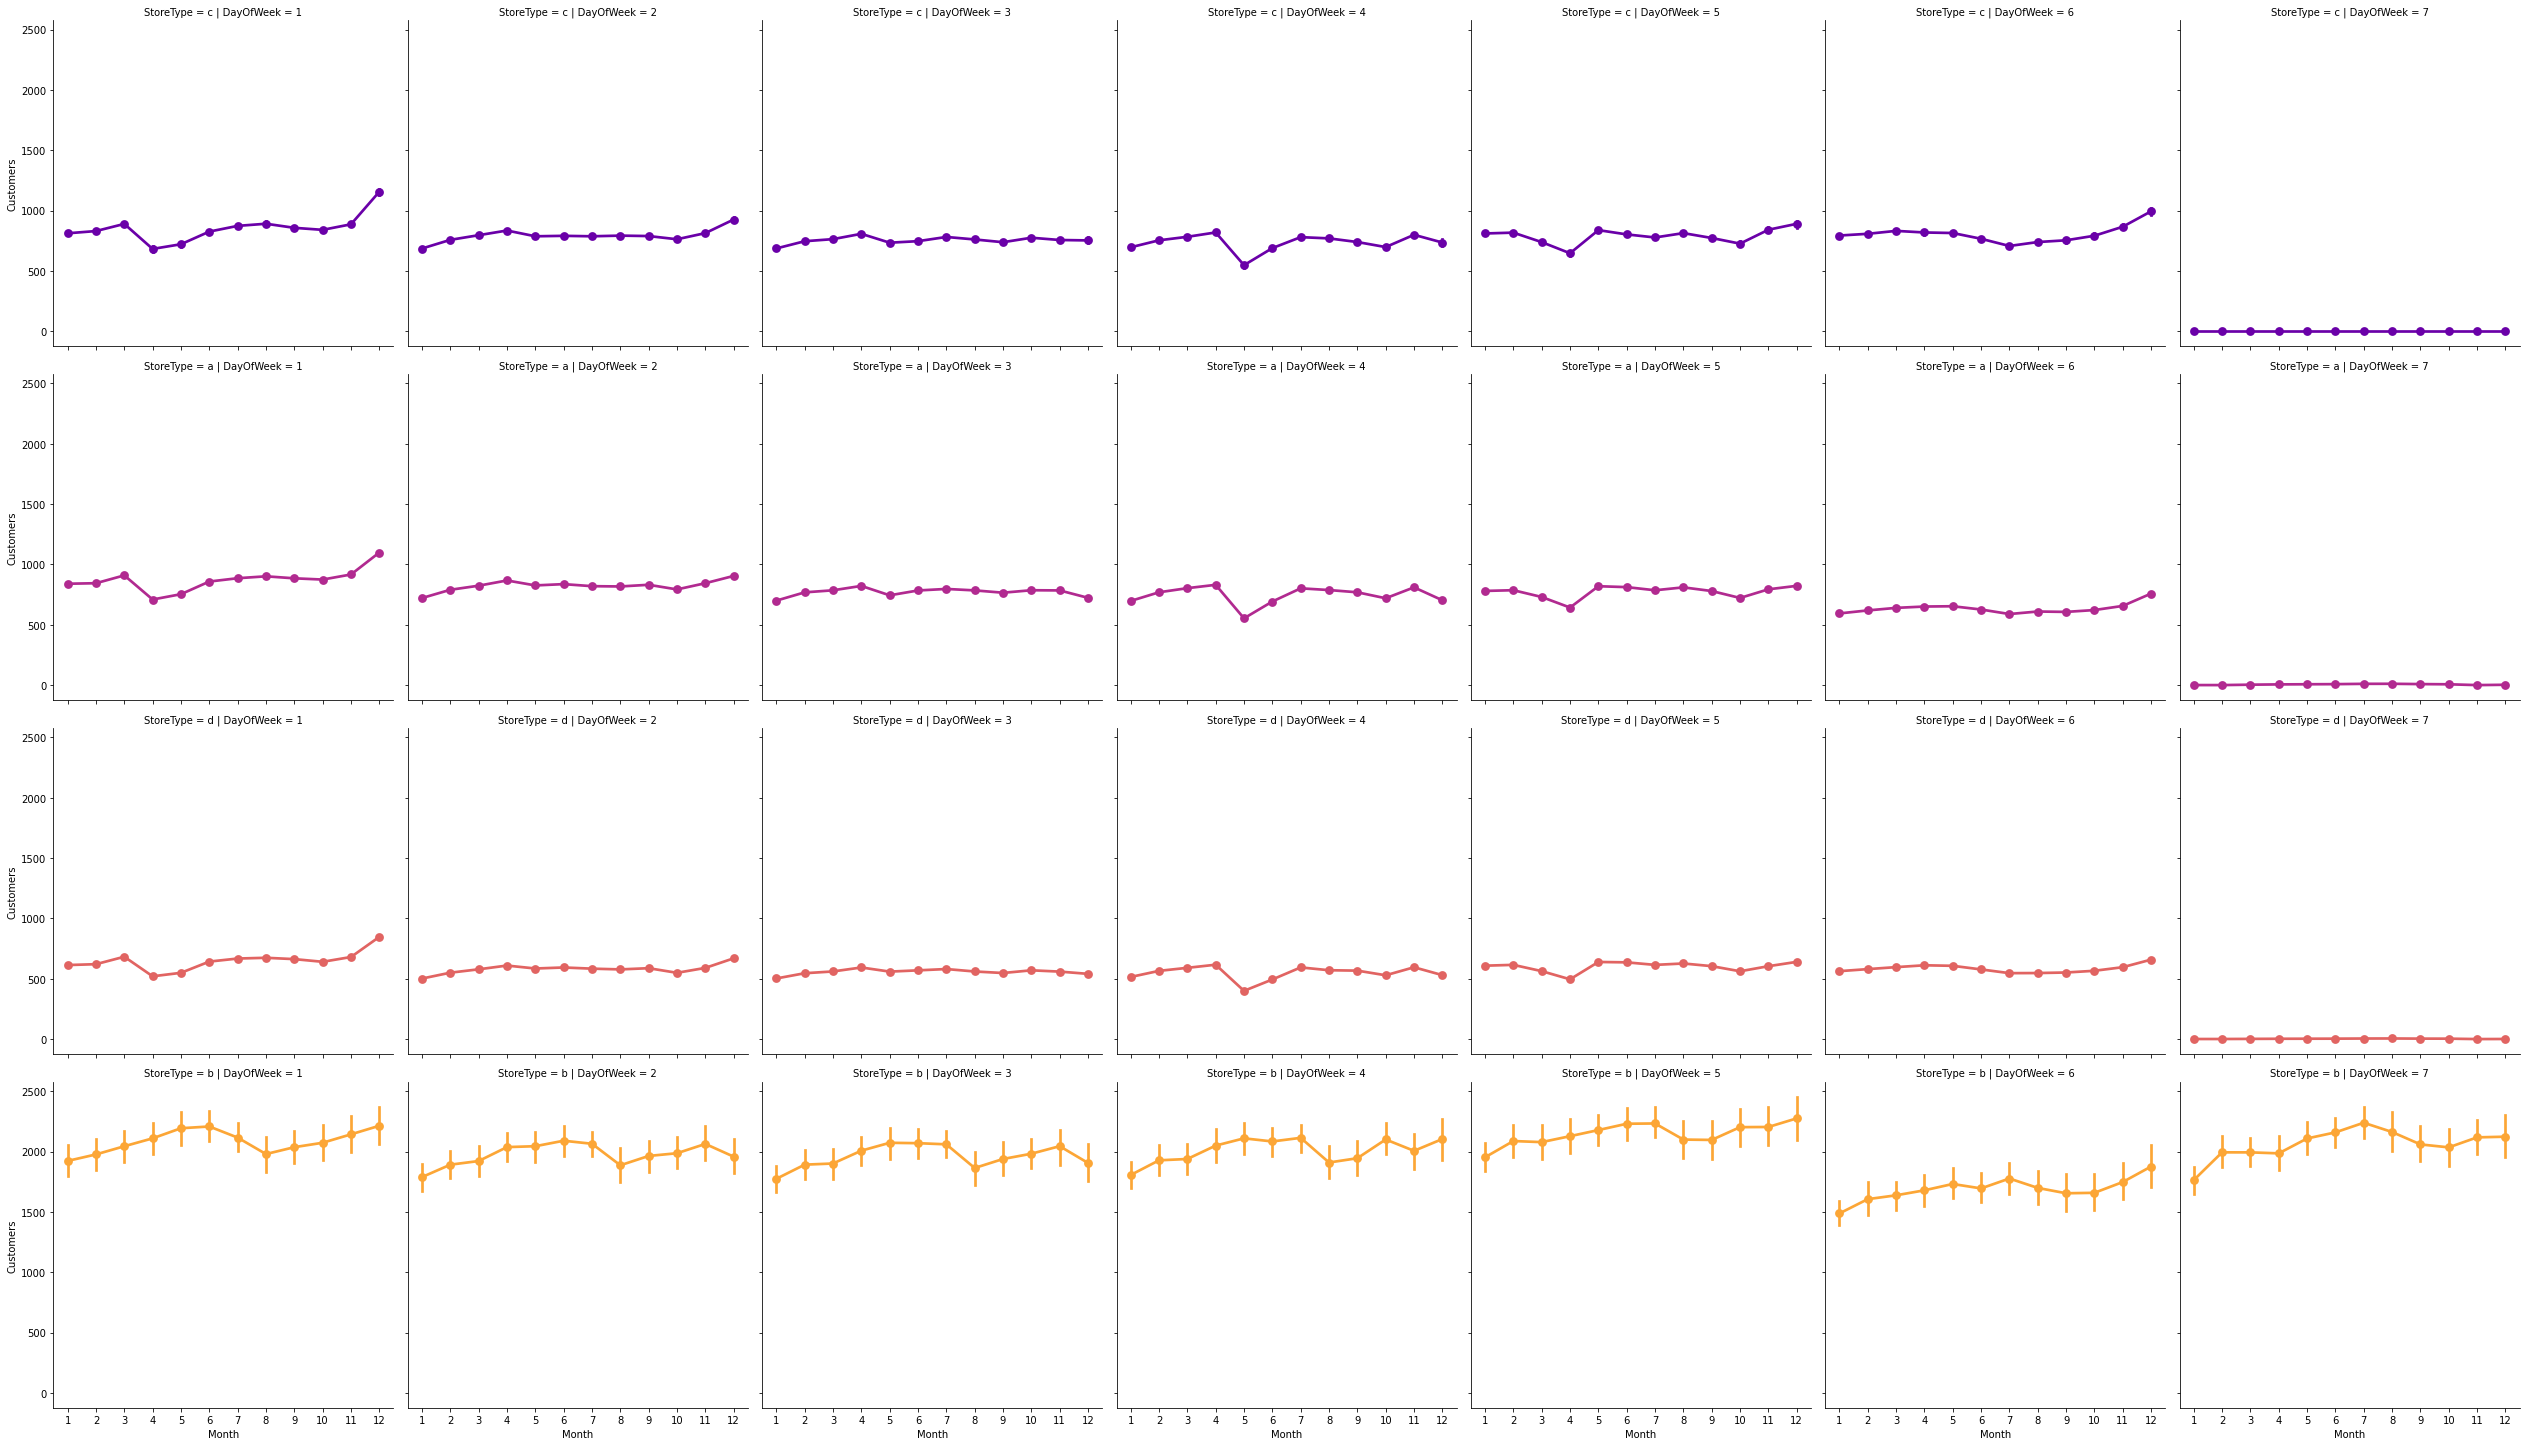

In [87]:
# Number of Customers for each day of week
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType a,c,d are closed on sundays as the number of customers are zero.
- storetype b has more customers and less number of customers on Saturday compared to other days.

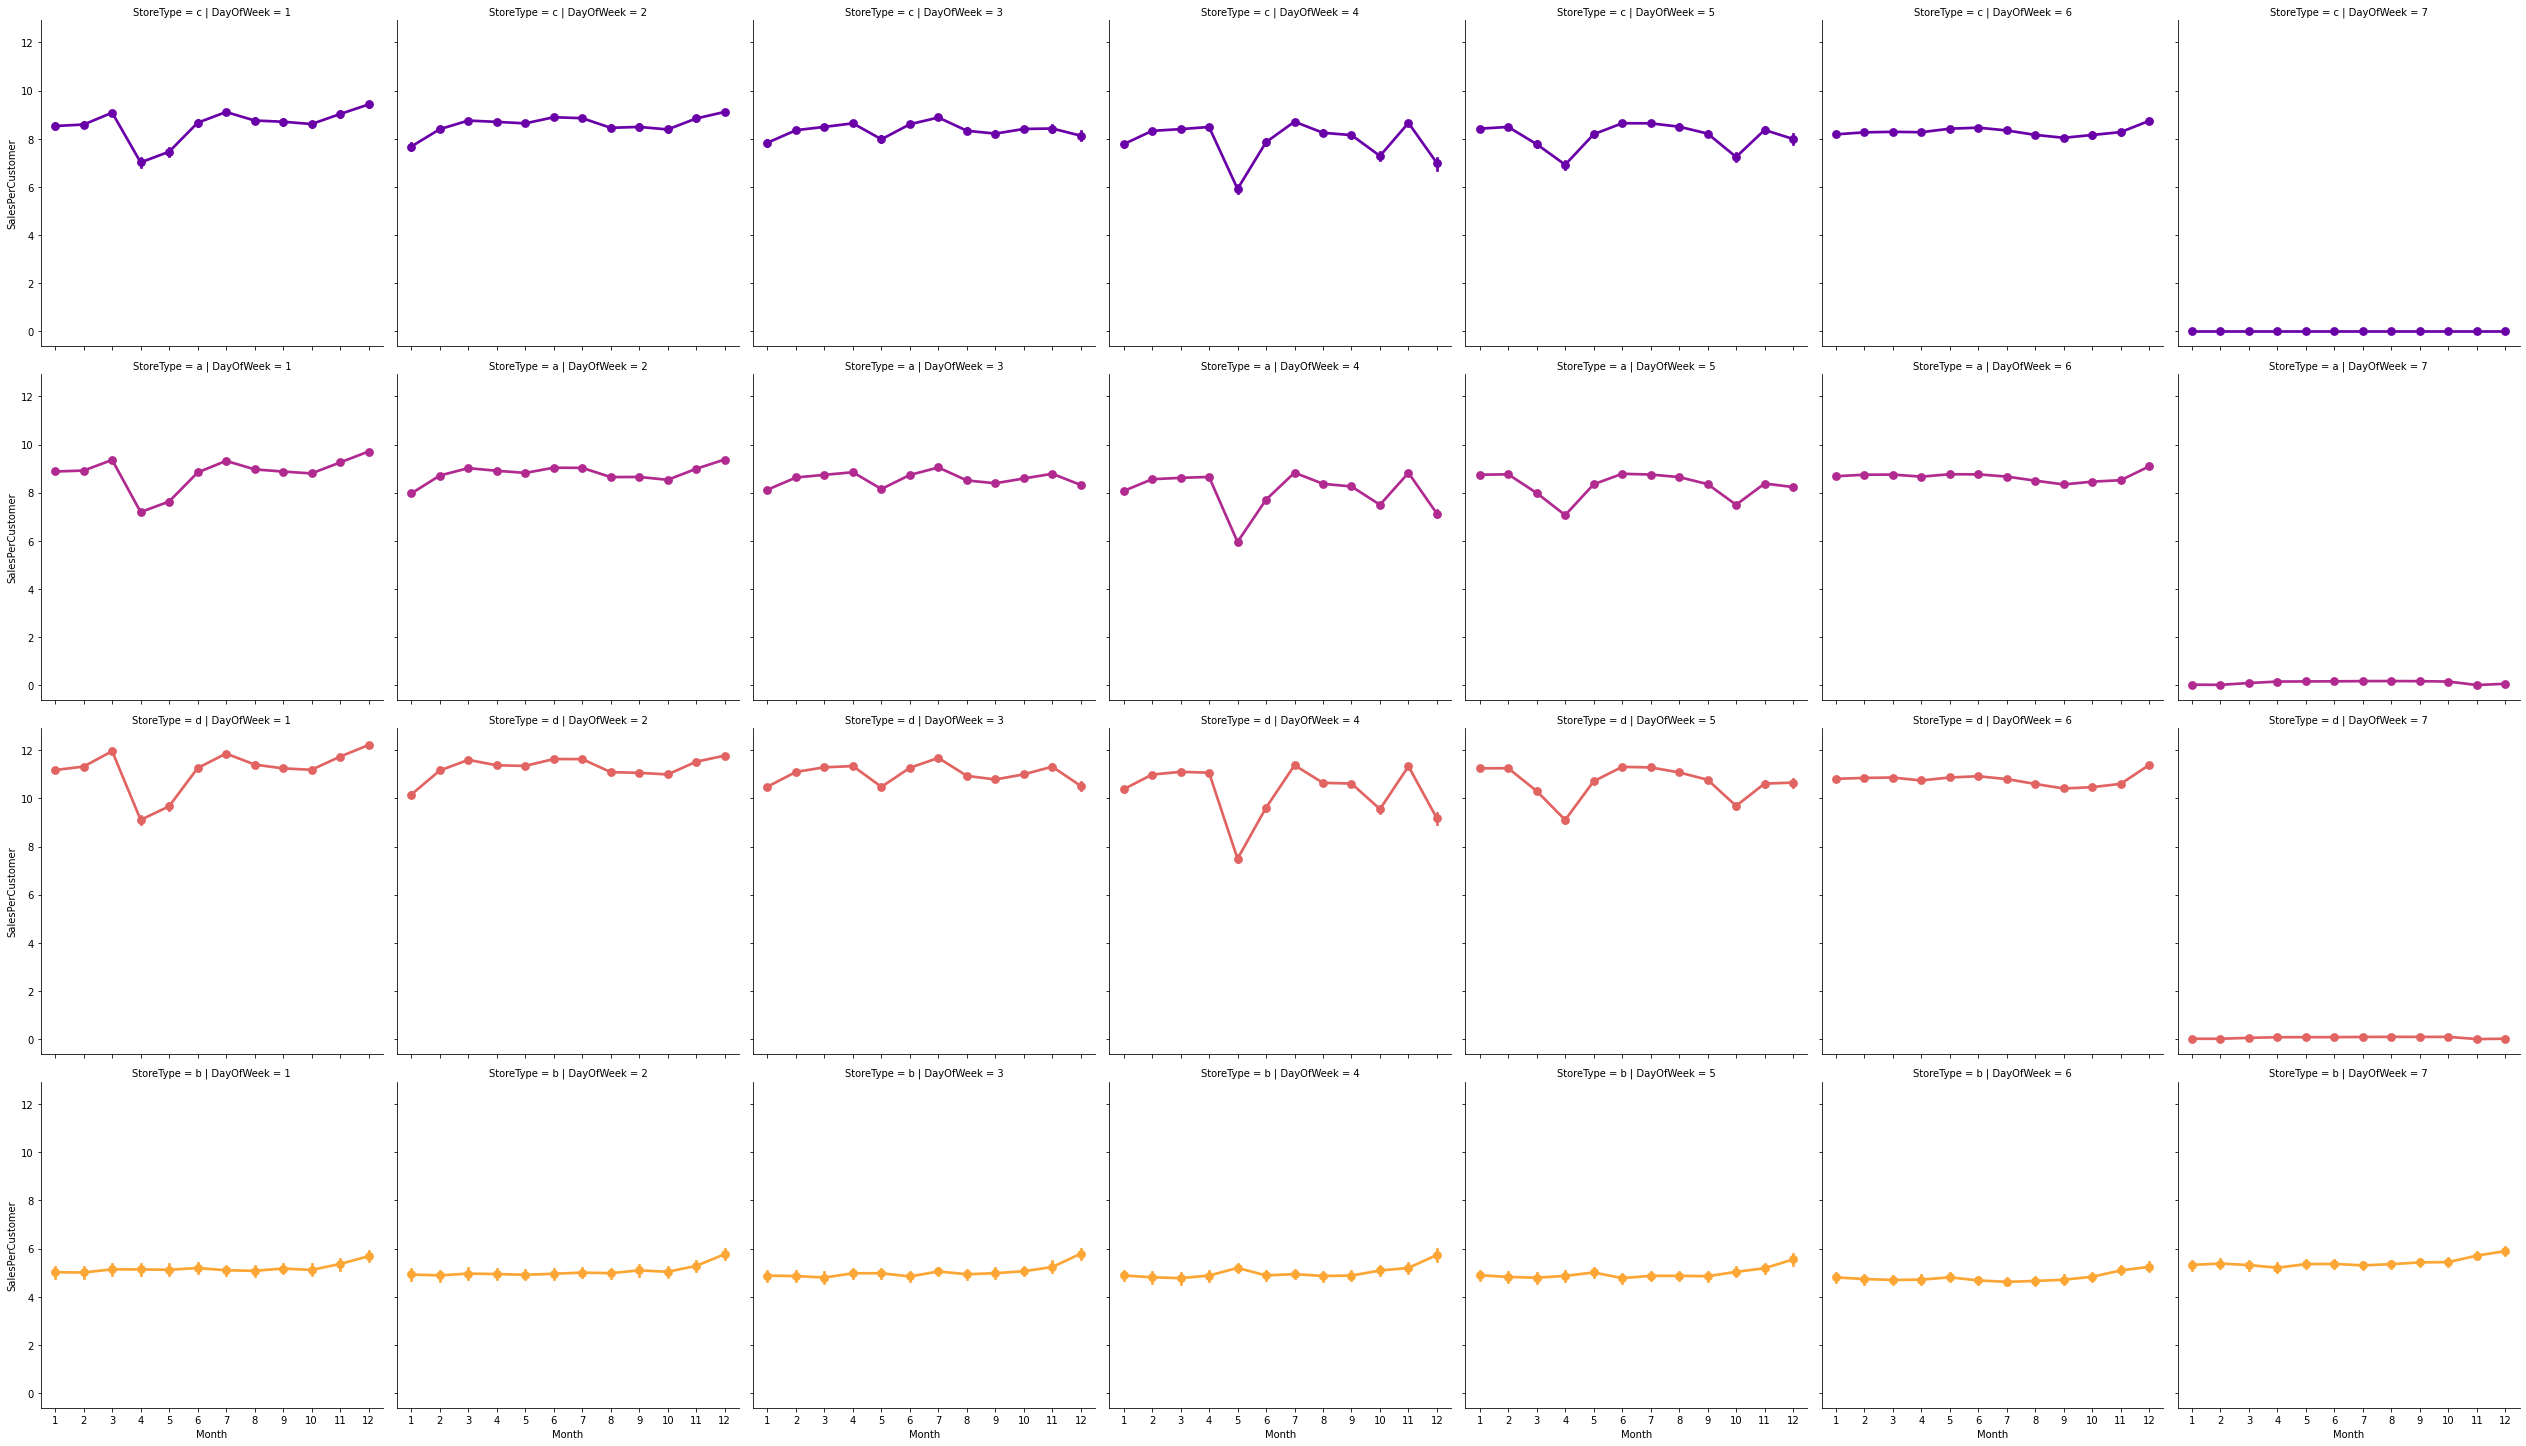

In [88]:
# SalesPerCustomer depending on Day of the week.
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'DayOfWeek', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- StoreType d has more salesPerCustomer value followed by a and c

In [89]:
train_store.groupby('SchoolHoliday')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
SchoolHoliday,,,,,,,,
0,835488.0,5620.979034,3862.873159,0.0,3506.0,5642.0,7749.0,41551.0
1,181721.0,6476.522207,3709.677337,0.0,4447.0,6197.0,8343.0,38367.0


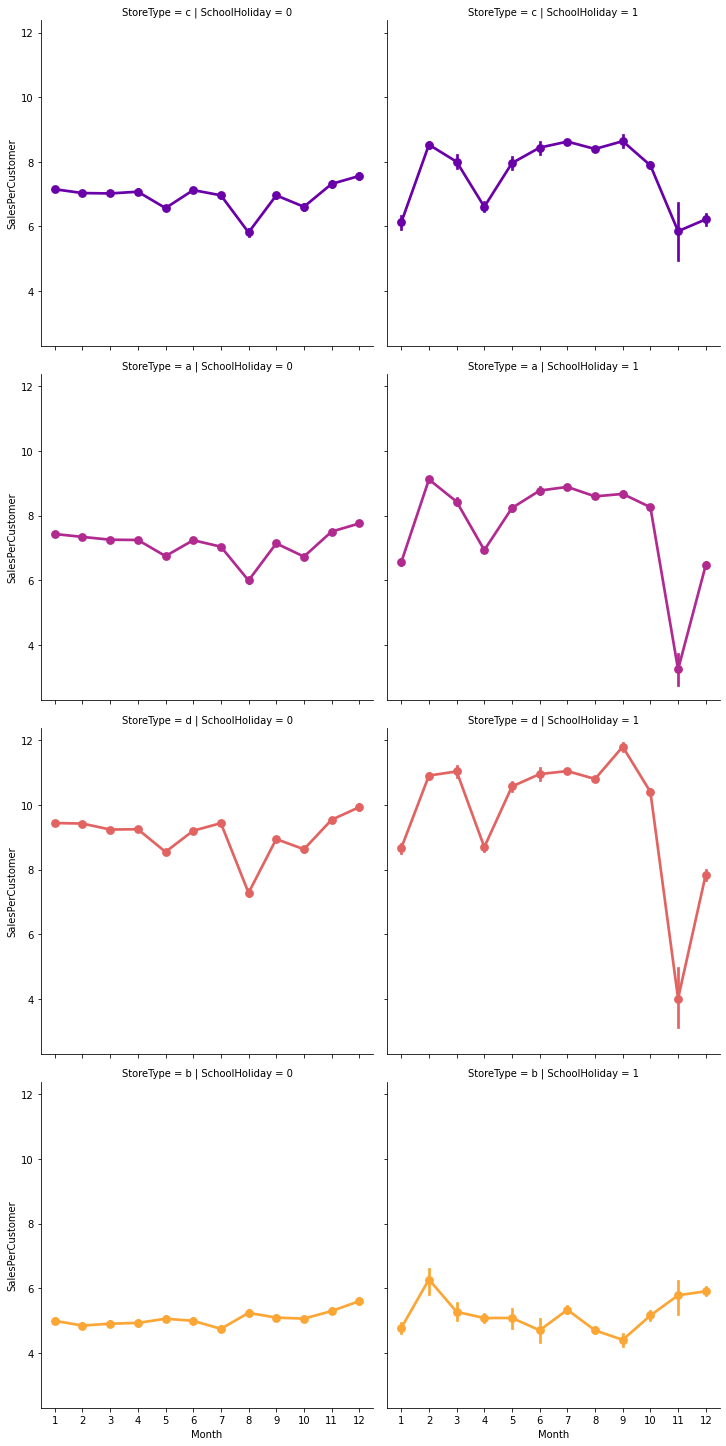

In [90]:
# Sales depending on SchoolHolidays
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'SchoolHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

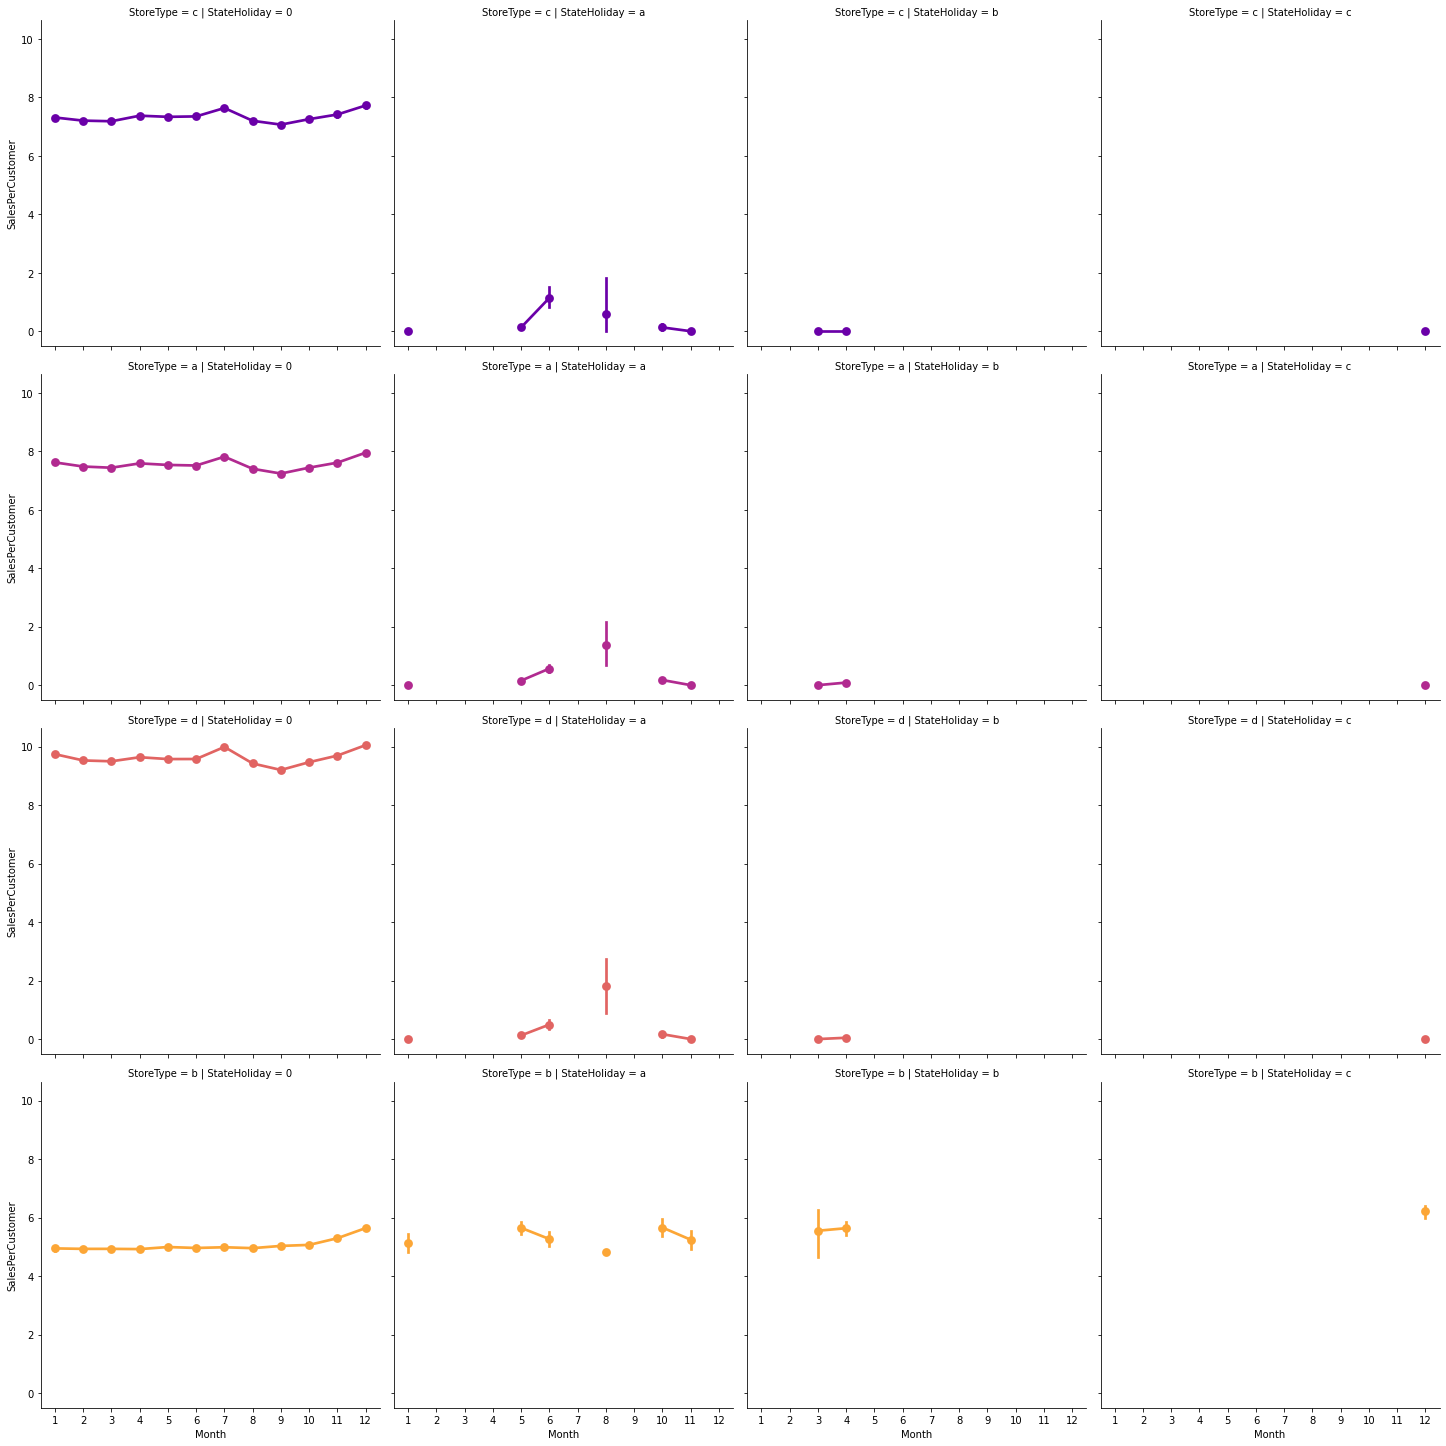

In [91]:
# SalesPerCustomer depending on StateHolidays
sns.factorplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StateHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

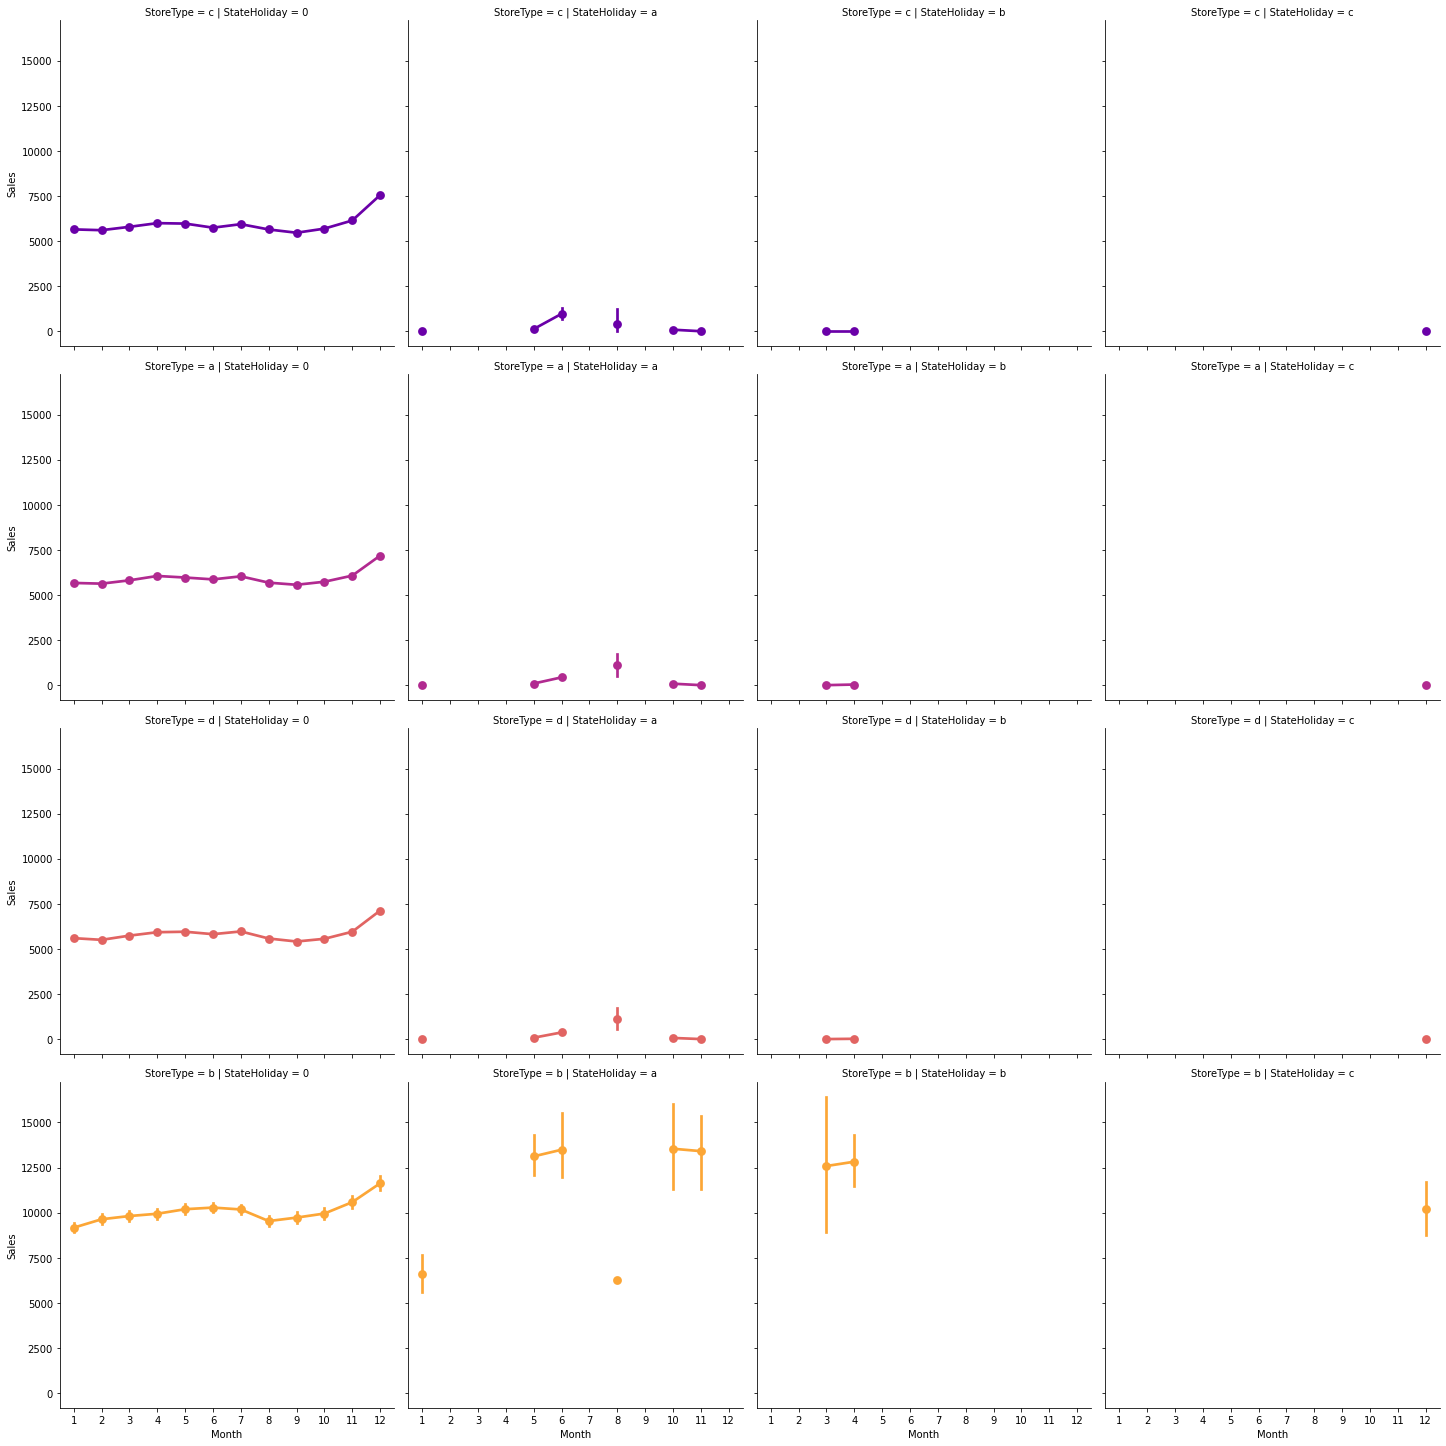

In [92]:
# Sales depending on StateHolidays
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StateHoliday', # per dayofweek type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType' # per store type in rows
              )

- storeTypes a, c, d are closed for Christmas, Easter and some public holidays while storeType b is open on most of the days.


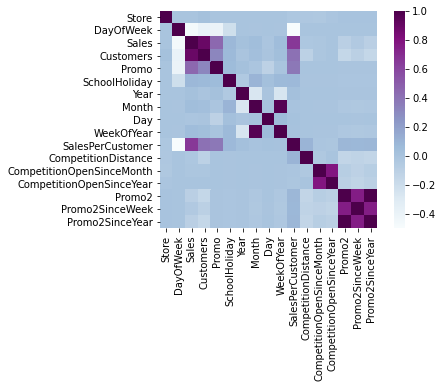

In [93]:
# correlation analysis
corr_all = train_store.drop('Open', axis = 1).corr()
sns.heatmap(corr_all,
            square = True, cmap = "BuPu") 

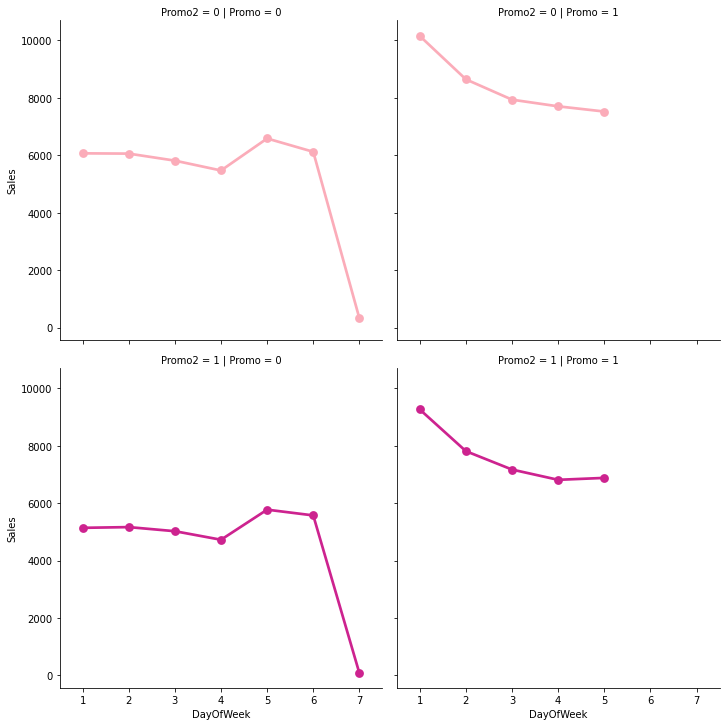

In [94]:
# sales per customer trends depending on promtions
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

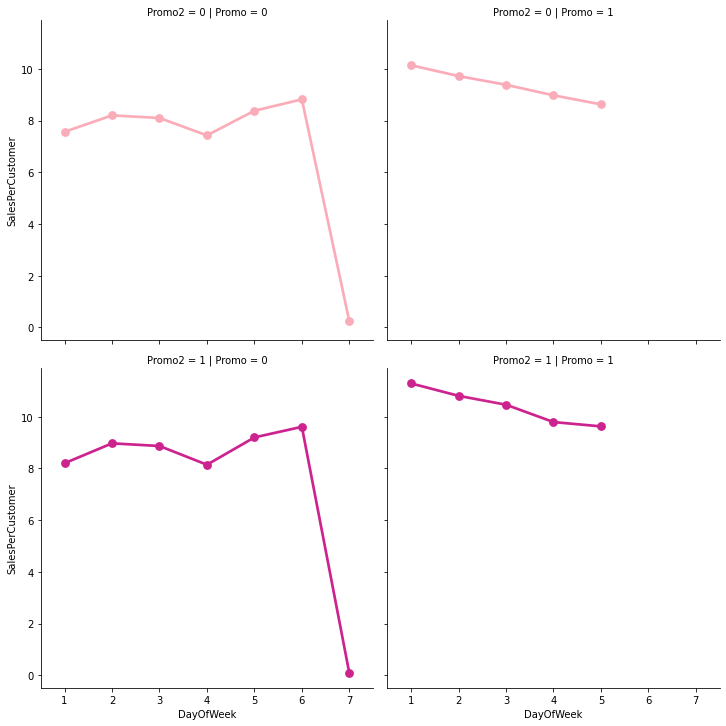

In [95]:
# sale per customer trends depending on promotion and day of the week
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "SalesPerCustomer", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

- when there is a promotion the sales are maximum on Monday.

#### EDA
- Store type b has more sales and more customers, but less salesPerCustomer value. this means people often visit this store for buying small things (less quantity).
- store type d has more salesPerCustomer value. it has a high buyer cart. the store can include a larger vareity of products.
- store a, c, d are closed on sundays, easter , christmas and some public holidays.
- store b is open on most of the days including sundays, christmas and easter.
- Mondays have maximum sales if there is a promotion.
- promo2 doesn't alone contribute much to the sales value.

# Time Series Analysis
- Trend
- Seasonality 
- autocorrelation

In [96]:
# merge the datasets based on store and index it on date-time series
train2 = pd.read_csv(r'/content/train.csv')
# merge datasets
train_store2 = pd.merge(train2, store, how = 'inner', on = 'Store')
#index the dataset on date-time series
train_store2.set_index(['Date'], inplace=True)
train_store2.index = pd.to_datetime(train_store2.index)
train_store2['Year'] = train_store2.index.year
train_store2['Month'] = train_store2.index.month
train_store2['Day'] = train_store2.index.day
train_store2['WeekOfYear'] = train_store2.index.weekofyear
train_store2.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
2015-07-30,1,4,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,30,31
2015-07-29,1,3,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,29,31
2015-07-28,1,2,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,28,31
2015-07-27,1,1,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,27,31


In [97]:
train_store2.isnull().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

**Seasonality trend**

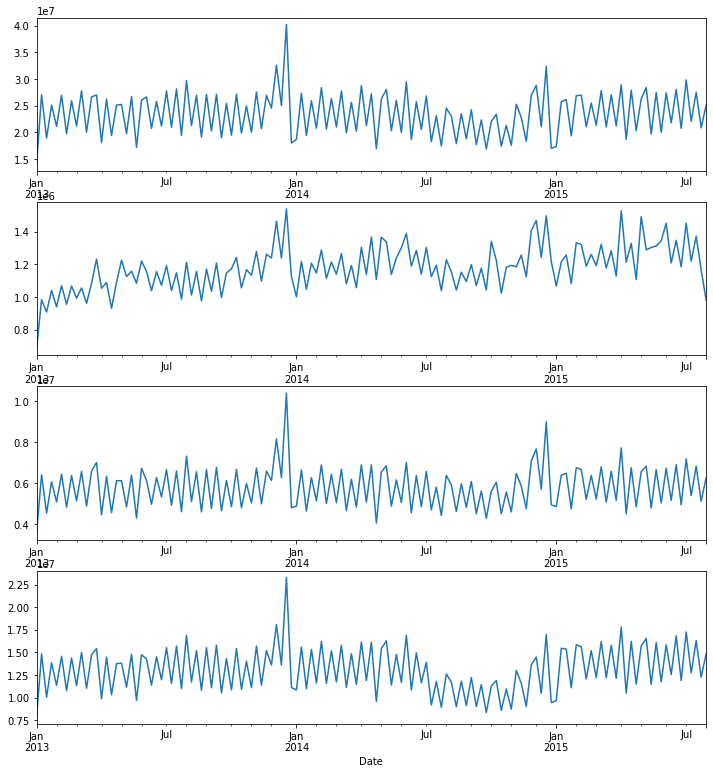

In [98]:
# preparation: input should be float type
train_store2['Sales'] = train_store2['Sales'] * 1.0

sales_a = train_store2[train_store2.StoreType == 'a']['Sales'] 
sales_b = train_store2[train_store2.StoreType == 'b']['Sales'] 
sales_c = train_store2[train_store2.StoreType == 'c']['Sales'] 
sales_d = train_store2[train_store2.StoreType == 'd']['Sales']
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# seasonality for the store types 
sales_a.resample('W').sum().plot( ax = ax1)
sales_b.resample('W').sum().plot( ax = ax2)
sales_c.resample('W').sum().plot( ax = ax3)
sales_d.resample('W').sum().plot( ax = ax4)

- StoreType a and c follow a similar trend over time. 
- Sales hike up during christmas, expecially during 2013 christmas in all stores.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


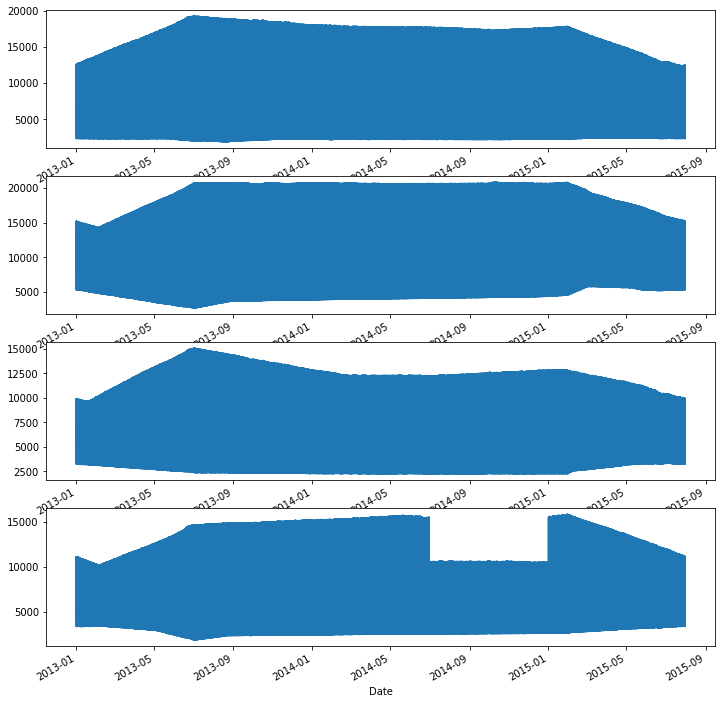

In [ ]:
# checking the trend and seasonality
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot( ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot( ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot( ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot( ax = ax4)


 **Auto-correlation**

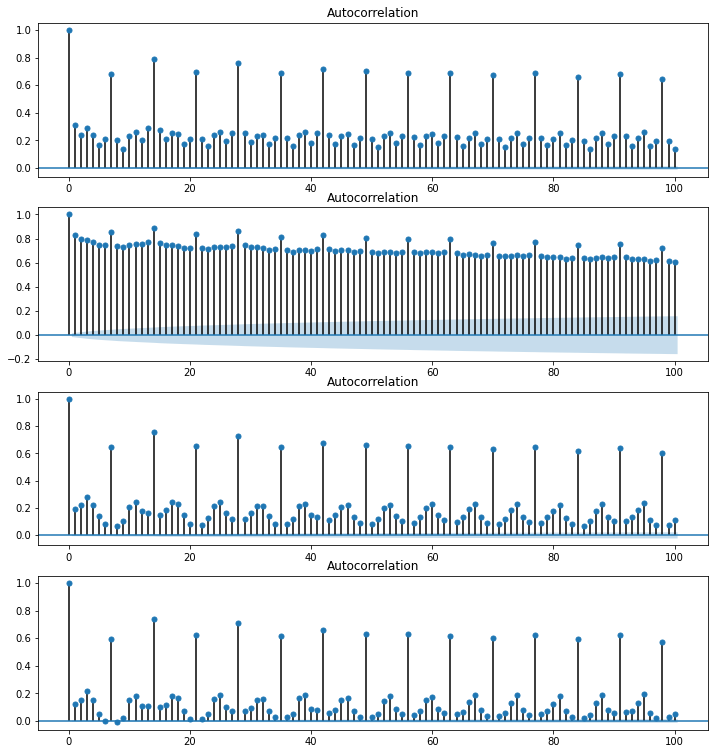

In [99]:
# figure for subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# acf for A
plot_acf(sales_a, lags = 100, ax = ax1)

# acf for B
plot_acf(sales_b, lags = 100, ax = ax2)

# acf for C
plot_acf(sales_c, lags = 100, ax = ax3)

# acf for D
plot_acf(sales_d, lags = 100, ax = ax4)

plt.show()

- Storetype a, c and d have a periodic distribution and the sales hike up every 7 days
- StoreType b has uniform distribution and there is a slight increase in sales every 7 days

# Forecast methods
- Prophet model

In [117]:

df = pd.read_csv(r'/content/train.csv',low_memory=False, parse_dates=True)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [118]:
# Consider the stores that are open
df = df[(df['Open'] != 0) & (df['Sales'] != 0)]
#df = df[(df['Store'] == 1)] 
df.shape

(844338, 9)

In [119]:
sales_ts = df[['Sales', 'Date']]
sales_ts['Date'] = pd.to_datetime(sales_ts['Date'])

# from the prophet documentation every variables should have specific names
sales_ts = sales_ts.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales_ts.head()

,y,ds
0,5263,2015-07-31
1,6064,2015-07-31
2,8314,2015-07-31
3,13995,2015-07-31
4,4822,2015-07-31


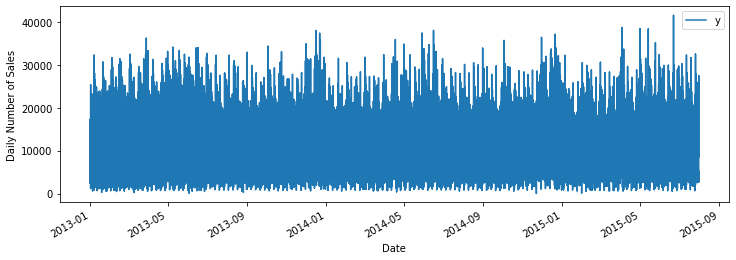

In [120]:
# plot daily sales of all stores 
ax = sales_ts.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

**Modelling Holidays**
- We consider the state and school holidays and combine them into one set of holidays

In [121]:
# state holidays
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
# school holidays
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

In [122]:
# convert state holidays into dataframe
state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
# convert school holidays into data frame
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

In [123]:
# concatenate state and school holidays
holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [125]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales_ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [126]:
# Taking the test set dataframe and collecting the dates
df_test = pd.read_csv(r'/content/test.csv',low_memory=False, parse_dates=True)
#future_df = df_test[(df_test['Store'] == 1)] 
future_df = df_test['Date']
future_df = pd.DataFrame({'ds':pd.to_datetime(future_df)})

In [127]:
forecast = my_model.predict(future_df)
# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
41081,2015-09-17,6648.448817,1193.020014,12561.668276
41082,2015-09-17,6648.448817,1004.336080,12296.876839
41083,2015-09-17,6648.448817,844.795269,12425.580711
41084,2015-09-17,6648.448817,991.887756,12685.952009
41085,2015-09-17,6648.448817,573.393919,12277.050333
41086,2015-09-17,6648.448817,766.418677,12561.968339
41087,2015-09-17,6648.448817,752.463919,12415.252617


In [132]:
# Convert the predicted values into a csv file
df_test['Sales_Pred'] = forecast['yhat']
df_test.to_csv('test_results.csv',index=False)

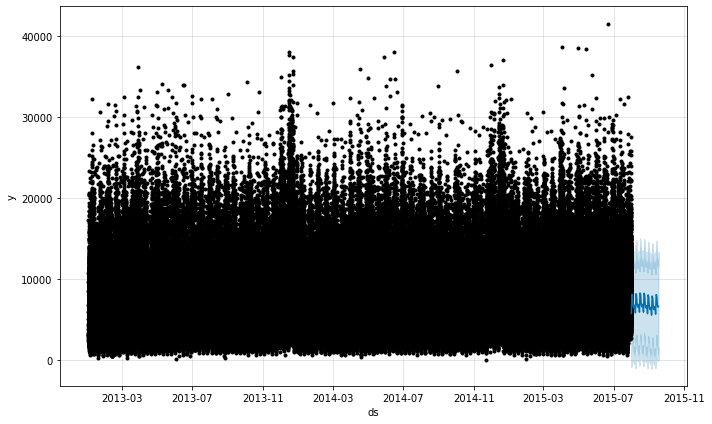

In [128]:
# visualizing predicions
my_model.plot(forecast);

**Results**
- The advantage of using Prophet model it takes into consideration of dependencies like holidays and seasonality.
- The drawback is features like promotions are not considered while predicting the future predictions.
- Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).


# New Section

In my solution here, my predictions are not completely correct as given a particular date the sales value is same independant of store or promotion. This is not correct. Currently, I am not able to figure out yet how to deal with it.
 So it will be very helpful if I could get some pointers to understand in which way I need to proceed.